## La régression 

Le but de la régression est de créer un modèle qui va savoir estimer une variable continue.

Nous allons donner à l'algorithme des données avec les valeurs réelles de la variable à prédire. Pendant l'entraînement, l'algorithme va apprendre à reconnaître la distribution de la variable à prédire ainsi que les caractéristiques qui vont permettre au modèle d'estimer avec le moins d'erreur possible notre cible.


## La régression en radiologie

Le but de cette étude, est d'estimer le plus précisément possible l'âge d'un individu en partant de sont IRM pondérée T1.


### Sélection du matériel

Avant de commencer nous allons sélectionné le matériel adapté à nos calculs. Le deep learning à besoin de cartes graphiques (GPU) afin de réduire le temps de calculs.

Appuyer sur "Exécution" -> "Modifier le type d'exécution" 

Dans "Accélérateur matériel" sélectionnez GPU puis appuyer sur enregistrer. 

Cliquez sur le lien ci-dessous : 

https://drive.google.com/open?id=1bqPk6SasqrUOBB7jfGLb8lRxNdBp9cBY

Cliquer droit sur le dossier data et appuyer sur ajouter à mon drive.

<img src="https://github.com/MorganGautherot/Tuto_MRI_ML/blob/master/tp_4/images/data_google_drive.png?raw=1" width="800" >

Exécutez la cellule ci-dessous et appuyer sur le lien proposé. 

Suivez les instructions et copier le code ci-dessous.

In [4]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


Les données sont maintenant dans votre environnement collab.

### Importation des packages

In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import nibabel
import sys
import os
import datetime

# Model architecture

from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D
from tensorflow.keras.layers import ReLU, PReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.callbacks import Callback, LearningRateScheduler, ModelCheckpoint


from keras.callbacks import Callback


import nibabel as nib
import seaborn as sns
from scipy.signal import find_peaks

In [0]:
# own bibli
os.chdir("/content/gdrive/My Drive/tp_4/data/utils/")
from callbacks import SaveHyperparameters, SaveMetrics
from utils import train_test_val
from models import model_Cole
from generators import generator_mri_regression

### Importation des hyperparamètres

In [0]:
SIZE = (193, 229, 193, 1)
LEARNING_RATE = 0.001

### Importation des données

Importation de nos jeux d'entraînement. Comme vous pouvez le voir ci-dessous, ce jeu de données contient tous les liens où l'on peut trouver nos images ainsi que des informations à propos de nos images.

In [8]:
data_train = pd.read_csv('/content/gdrive/My Drive/tp_4/data/train.csv')
data_train.head()

,id,t1_norm,age
0,21,/content/gdrive/My Drive/tp_4/data/train/sub-2...,21.0
1,276,/content/gdrive/My Drive/tp_4/data/train/sub-2...,20.0
2,129,/content/gdrive/My Drive/tp_4/data/train/sub-1...,23.0
3,94,/content/gdrive/My Drive/tp_4/data/train/sub-9...,24.0
4,619,/content/gdrive/My Drive/tp_4/data/train/sub-6...,24.0



Vous pouvez voir ci-dessous la distribution de l'âge du jeu d'entraînement.

<img src='https://github.com/MorganGautherot/Tuto_MRI_ML/blob/master/tp_4/data/distrib_age_train.png?raw=1' >


Importation de nos jeux de test. Comme vous pouvez le voir ci-dessous, ce jeu de données contient tous les liens où l'on peut trouver nos images ainsi que des informations à propos de nos images.

In [9]:
data_test = pd.read_csv('/content/gdrive/My Drive/tp_4/data/test.csv')
data_test.head()

,id,t1_norm,age
0,331,/content/gdrive/My Drive/tp_4/data/test/sub-33...,23.0
1,64,/content/gdrive/My Drive/tp_4/data/test/sub-06...,20.0
2,426,/content/gdrive/My Drive/tp_4/data/test/sub-42...,23.0
3,230,/content/gdrive/My Drive/tp_4/data/test/sub-23...,21.0
4,201,/content/gdrive/My Drive/tp_4/data/test/sub-20...,22.0


Vous pouvez voir ci-dessous la distribution de l'âge du jeu de test.

<img src='https://github.com/MorganGautherot/Tuto_MRI_ML/blob/master/tp_4/data/distrib_age_test.png?raw=1' >

Les intensités de nos images IRM ont été normalisé par la technique vue dans le notebook 3.

On est passé de cette représentation de nos intensité pour les données d'entraînement :

<img src='https://github.com/MorganGautherot/Tuto_MRI_ML/blob/master/tp_4/data/t1_unnorm_distribution.png?raw=1' > 
          
A cette distribution d'intensité après normalisation : 


<img src='https://github.com/MorganGautherot/Tuto_MRI_ML/blob/master/tp_4/data/t1_norm_distribution.png?raw=1' > 
   

Souvent en deep learning les jeux d'entraînement et de test sont trop gros pour être charger en mémoire. 

Pour entraîner nos modèles nous sommes obligé d'entraîner nos modèles par mini-batch. Un batch est une fraction de notre jeu d'entraînement. 

<img src='https://github.com/MorganGautherot/Tuto_MRI_ML/blob/master/tp_4/data/mini-batch.png?raw=1' >

Prenons un jeu d'entraînement X avec $n_x$ le nombre de variables et $m$ le nombre d'exemples. 

Imaginons que notre jeu de données est égale à $m$=50 000 000, l'entraînement de ce modèle est impossible. Pour rendre l'entraînement possible, nous allons entraîner plusieurs mini-batch $X^{\{i\}}$ afin d'entraîner tous nos exemples séquentiellement.

Pour simuler ces mini-batch nous allons utiliser des générateurs qui vont fournir à l'algorithme les données par séquence.

In [0]:
# Nous allons créer de nouveau jeu de données contenant seulement les variables utilent à l'entraînement de notre modèle
train = data_train.loc[:, ('t1_norm', 'age')]

# Nous allons créer de nouveau jeu de données contenant seulement les variables utilent aux tests de notre modèle
test = data_test.loc[:, ('t1_norm', 'age')]

# On précise le nombre d'exemple que va contenir chaque batch
batch_size = 4

generator_train = generator_mri_regression(list_path=train, batch_size=batch_size, shuffle=True)

generator_test = generator_mri_regression(list_path=test, batch_size=batch_size, shuffle=True)


### La profondeur des architectures



```
# Ce texte est au format code
```

#### Architecture de base

Dans un projet de machine learning nous allons toujours commencer par entraîner un modèle très simple pour voir à quel point le problème est compris. 

Plus tard chaque amélioration pourra être comparée avec ce modèle dit "de base" afin de voir l'amélioration de ces performances.

Comme vous pouvez le voir sur le schéma ci-dessous le modèle est composé de deux couches de convolution, une couche de maxpooling et une couche. Ensuite nous allons transformer nos matrices en vecteur c'est la partie "flatten" sur le schéma et pour finir nous aurons une couche complétement connectés.

<img src="https://github.com/MorganGautherot/Tuto_MRI_ML/blob/master/tp_4/data/baseline1.png?raw=1" >

Ci-dessous vous pouvez voir l'implémentation en keras du schéma ci-dessus.

In [0]:
# Model
def base_model(size):
    """
    Model of "Predictiong brain age with deep learning from raw imaging data results in a reliable and heritable biomarker"

    Inputs:
        - model_options:
        - weights_path: path to where weights should be saved
    Output:
        - nets = list of NeuralNets (CNN1, CNN2)def Unet_3D_model(modalities, patch_size, filters=32, dropout_rate=0.2):

    """
    model = Sequential()
    model.add(Conv3D(filters=8,
                     kernel_size=(3, 3, 3),
                     activation='relu',
                     input_shape=size,
                     name="conv_1_1"))
    model.add(Conv3D(filters=8,
                     kernel_size=(3, 3, 3),
                     activation='relu',
                     name="conv_1_2"))
    model.add(MaxPooling3D(pool_size=(2, 2, 2),
                           strides=(2, 2, 2)))
    model.add(Flatten())
    model.add(Dense(units=1,
                    name="d_2"))
    return model

En utilisant la fonction "summary" nous avons le détail des paramètres qui compose notre modèle couche par couche.

In [13]:
model = base_model(SIZE)
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1_1 (Conv3D)            (None, 191, 227, 191, 8)  224       
_________________________________________________________________
conv_1_2 (Conv3D)            (None, 189, 225, 189, 8)  1736      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 94, 112, 94, 8)    0         
_________________________________________________________________
flatten (Flatten)            (None, 7917056)           0         
_________________________________________________________________
d_2 (Dense)                  (None, 1)                 7917057   
Total params: 7,919,017
Trainable params: 7,919,017
Non-trainable params: 0
_________________________________________________________________


Dans cette partie nous initialisons nos "callbacks", ces fonctions servent à sauvegarder des informations tout au long de l'entraînement de nos données.

In [0]:
# Call back initialization
test_name = 'baseline_' + datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")

training_path = '/content/'+test_name
os.mkdir(training_path)

hyperparameters = SaveHyperparameters(training_path, LEARNING_RATE, batch_size, 100, False, 0, 0, 'test_baseline')

save_metrics = SaveMetrics(training_path)

filepath="/content/"+test_name+"/model_saved/"
os.mkdir(filepath)

checkpoint = ModelCheckpoint(filepath+"HCP-test_weights-improvement-{epoch:02d}-{val_mean_absolute_error:.2f}.hdf5", monitor='val_mean_absolute_error', verbose=1, save_best_only=True, mode='min')

callbacks_list = [checkpoint, save_metrics]

Maintenant nous allons compiler notre modèle en spécifiant la fonction de coût que nous voulons utiliser pour entraîner notre modèle, la fonction d'optimisation que nous voulons utiliser pour mettre à jour nos paramètres et la métrique de performance qui sera calculée pour suivre l'évolution des performances tout au long de notre entraînement.

In [0]:
# Model initialization
model.compile(loss=['mae'],
              optimizer=SGD(lr=LEARNING_RATE),
              metrics=['mae'])

Maintenant, notre modèle est prêt pour l'entraînement. 

Nous donnons le générateur d'entraînement, le générateur de test, et le nombre d'itérations d'entraînement.

In [16]:
model.fit_generator(generator=generator_train.loader(),
                    steps_per_epoch=generator_train.get_len(),
                    epochs=5, 
                    verbose=1,
                    validation_data=generator_test.loader(),
                    validation_steps=generator_test.get_len(),
                    validation_freq=1,
                    shuffle=True,
                    initial_epoch=0,
                    callbacks=callbacks_list)

Epoch 1/5


KeyboardInterrupt: ignored

Votre modèle s'entraîne, cet entraînement peut être très long. Pendant l'entraînement nous allons sauvegarder automatiquement les modèles les plus performant et l'évolution des performances durant l'entraînement. 

Vous pouvez ci-dessous charger un modèle entraîner pendant 100 itérations avec le même jeu de données.

In [0]:
model.load_weights('/content/gdrive/My Drive/tp_4/data/models/model-baseline_it-100_data-100.hdf5')

Avec les données sauvegardées on peut visualiser l'évolution des performances au cours de l'entraînement.

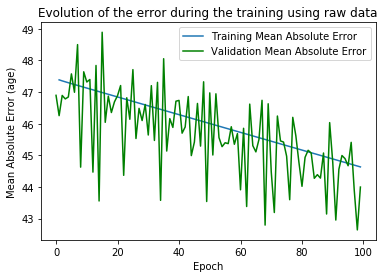

In [18]:
data_training_base = pd.read_csv("/content/gdrive/My Drive/tp_4/data/training_data/metrics_baseline_100_100.csv")
plt.plot(data_training_base.loc[1:, 'epoch'], data_training_base.loc[1:, 'train_loss'], label='Training Mean Absolute Error')
plt.plot(data_training_base.loc[0:, 'epoch'], data_training_base.loc[0:, 'val_loss'], label='Validation Mean Absolute Error', color='green')
plt.legend(loc='upper right')
plt.title('Evolution of the error during the training using raw data')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error (age)')
plt.show()

On peut voir d'après le graphique ci-dessus que notre modèle souffre de sous-entraînement. Notre modèle n'est pas assez complexe pour comprendre le phénomène à modéliser. 

#### Modèle intermédiaire

Nous allons donc utiliser un modèle plus complexe afin de voir s'il arrive à mieux comprendre les phénomènes à utiliser. Vous pouvez voir le schéma de notre nouveau modèle ci-dessous.

<img src="https://github.com/MorganGautherot/Tuto_MRI_ML/blob/master/tp_4/data/V2_model.png?raw=1" >

In [0]:
# Model
def model_baseV2(size):
    """
    Model of "Predictiong brain age with deep learning from raw imaging data results in a reliable and heritable biomarker"

    Inputs:
        - model_options:
        - weights_path: path to where weights should be saved
    Output:
        - nets = list of NeuralNets (CNN1, CNN2)def Unet_3D_model(modalities, patch_size, filters=32, dropout_rate=0.2):

    """
    model = Sequential()
    model.add(Conv3D(filters=8,
                     kernel_size=(3, 3, 3),
                     activation='relu',
                     input_shape=size,
                     name="conv_1_1"))
    model.add(Conv3D(filters=8,
                     kernel_size=(3, 3, 3),
                     activation='relu',
                     name="conv_1_2"))
    model.add(MaxPooling3D(pool_size=(2, 2, 2),
                           strides=(2, 2, 2)))
    model.add(Conv3D(filters=16,
                     kernel_size=(3, 3, 3),
                     activation='relu',
                     input_shape=size,
                     name="conv_2_1"))
    model.add(Conv3D(filters=16,
                     kernel_size=(3, 3, 3),
                     activation='relu',
                     name="conv_2_2"))
    model.add(MaxPooling3D(pool_size=(2, 2, 2),
                           strides=(2, 2, 2)))
    model.add(Flatten())
    model.add(Dense(units=1,
                    name="d_2"))
    return model

In [20]:
model_V2 = model_baseV2(SIZE)
model_V2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1_1 (Conv3D)            (None, 191, 227, 191, 8)  224       
_________________________________________________________________
conv_1_2 (Conv3D)            (None, 189, 225, 189, 8)  1736      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 94, 112, 94, 8)    0         
_________________________________________________________________
conv_2_1 (Conv3D)            (None, 92, 110, 92, 16)   3472      
_________________________________________________________________
conv_2_2 (Conv3D)            (None, 90, 108, 90, 16)   6928      
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 45, 54, 45, 16)    0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1749600)          

In [0]:
# Call back initialization
test_name = 'model_V2_' + datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")

training_path = '/content/'+test_name
os.mkdir(training_path)

hyperparameters = SaveHyperparameters(training_path, LEARNING_RATE, batch_size, 100, False, 0, 0, 'test_baseline')

save_metrics = SaveMetrics(training_path)

filepath="/content/"+test_name+"/model_saved/"
os.mkdir(filepath)

checkpoint = ModelCheckpoint(filepath+"HCP-test_weights-improvement-{epoch:02d}-{val_mean_absolute_error:.2f}.hdf5", monitor='val_mean_absolute_error', verbose=1, save_best_only=True, mode='min')

callbacks_list = [checkpoint, save_metrics]

In [0]:
# Model initialization
model_V2.compile(loss=['mae'],
              optimizer=SGD(lr=LEARNING_RATE),
              metrics=['mae'])

In [0]:
model_V2.fit_generator(generator=generator_train.loader(),
                    steps_per_epoch=generator_train.get_len(),
                    epochs=5, 
                    verbose=1,
                    validation_data=generator_test.loader(),
                    validation_steps=generator_test.get_len(),
                    validation_freq=1,
                    shuffle=True,
                    initial_epoch=0,
                    callbacks=callbacks_list)

Votre modèle s'entraîne, cet entraînement peut être très long. Pendant l'entraînement nous allons sauvegarder automatiquement les modèles les plus performants et l'évolution des performances durant l'entraînement. 

Vous pouvez ci-dessous charger un modèle entraîner pendant 100 itérations avec le même jeu de données.

In [0]:
model_V2.load_weights('/content/gdrive/My Drive/tp_4/data/models/model-v2_it-100_data-100.hdf5')

Avec les données sauvegardées on peut visualiser l'évolution des performances au cours de l'entraînement.

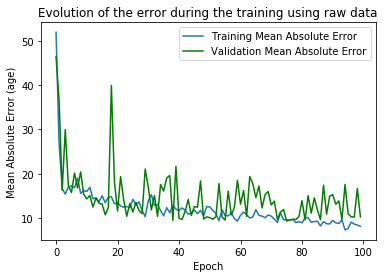

In [24]:
data_training_V2 = pd.read_csv("/content/gdrive/My Drive/tp_4/data/training_data/metrics_v2_100_100.csv")
plt.plot(data_training_V2.loc[:, 'epoch'], data_training_V2.loc[:, 'train_loss'], label='Training Mean Absolute Error')
plt.plot(data_training_V2.loc[:, 'epoch'], data_training_V2.loc[:, 'val_loss'], label='Validation Mean Absolute Error', color='green')
plt.legend(loc='upper right')
plt.title('Evolution of the error during the training using raw data')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error (age)')
plt.show()

On peut voir d'après le graphique ci-dessus que notre modèle comprend mieux notre phénomène que le modèle précédent. Nous allons prendre ci-dessous un modèle plus complexe qui nous donnera plus de performance.

#### Architecture plus élaborée

Ce modèle est plus performant que le précédent en ayant 5 blocks au lieu de 2 précédemment (voir le schéma ci-dessous).

<img src="https://github.com/MorganGautherot/Tuto_MRI_ML/blob/master/tp_4/data/cole_model1.png?raw=1" >

In [0]:
# block of Cole model
def block_model_Cole(model, nb_block):
    model.add(Conv3D(filters=8*pow(2,nb_block),
                     kernel_size=(3, 3, 3),
                     padding='same',
                     activation='relu',
                     name="conv_"+str(nb_block+1)+"_1"))
    model.add(Conv3D(filters=8*pow(2,nb_block),
                     kernel_size=(3, 3, 3),
                     padding='same',
                     activation=None,
                     name="conv_"+str(nb_block+1)+"_2"))
    model.add(BatchNormalization(name="bn_"+str(nb_block+1)+"_3", axis=4))
    model.add(ReLU(name="relu_conv_"+str(nb_block+1)+"_4"))
    model.add(MaxPooling3D(pool_size=(2, 2, 2),
                           strides=(2, 2, 2)))
    return model

# Model
def cole_model(size):
    """
    Model of "Predictiong brain age with deep learning from raw imaging data results in a reliable and heritable biomarker"

    Inputs:
        - model_options:
        - weights_path: path to where weights should be saved
    Output:
        - nets = list of NeuralNets (CNN1, CNN2)def Unet_3D_model(modalities, patch_size, filters=32, dropout_rate=0.2):

    """
    model = Sequential()
    model.add(Conv3D(filters=8,
                     kernel_size=(3, 3, 3),
                     padding='same',
                     activation='relu',
                     input_shape=size,
                     name="conv_1_1"))
    model.add(Conv3D(filters=8,
                     kernel_size=(3, 3, 3),
                     padding='same',
                     activation=None,
                     name="conv_1_2"))
    model.add(BatchNormalization(name='bn_1_3', axis=4))
    model.add(ReLU(name='relu_conv_1_4'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2),
                           strides=(2, 2, 2)))
    model = block_model_Cole(model, 1)
    model = block_model_Cole(model, 2)
    model = block_model_Cole(model, 3)
    model = block_model_Cole(model, 4)
    
    model.add(Flatten())
    model.add(Dense(units=1,
                    name="d_6"))
    return model


In [58]:
model_cole =  cole_model(SIZE)
model_cole.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1_1 (Conv3D)            (None, 193, 229, 193, 8)  224       
_________________________________________________________________
conv_1_2 (Conv3D)            (None, 193, 229, 193, 8)  1736      
_________________________________________________________________
bn_1_3 (BatchNormalization)  (None, 193, 229, 193, 8)  32        
_________________________________________________________________
relu_conv_1_4 (ReLU)         (None, 193, 229, 193, 8)  0         
_________________________________________________________________
max_pooling3d_27 (MaxPooling (None, 96, 114, 96, 8)    0         
_________________________________________________________________
conv_2_1 (Conv3D)            (None, 96, 114, 96, 16)   3472      
_________________________________________________________________
conv_2_2 (Conv3D)            (None, 96, 114, 96, 16)  

In [0]:
# Model initialization
model_cole.compile(loss=['mae'],
              optimizer=SGD(lr=LEARNING_RATE),
              metrics=['mae'])

In [0]:
# Call back initialization
test_name = 'cole_' + datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")

training_path = '/content/'+test_name
os.mkdir(training_path)

hyperparameters = SaveHyperparameters(training_path, LEARNING_RATE, batch_size, 100, False, 0, 0, 'test_baseline')

save_metrics = SaveMetrics(training_path)

filepath="/content/"+test_name+"/model_saved/"
os.mkdir(filepath)

checkpoint = ModelCheckpoint(filepath+"HCP-test_weights-improvement-{epoch:02d}-{val_mean_absolute_error:.2f}.hdf5", monitor='val_mean_absolute_error', verbose=1, save_best_only=True, mode='min')

callbacks_list = [checkpoint, save_metrics]

In [0]:
model_cole.fit_generator(generator=generator_train.loader(),
                    steps_per_epoch=generator_train.get_len(),
                    epochs=5, 
                    verbose=1,
                    validation_data=generator_test.loader(),
                    validation_steps=generator_test.get_len(),
                    validation_freq=1,
                    shuffle=True,
                    initial_epoch=0,
                    callbacks=callbacks_list)

Votre modèle s'entraîne, cet entraînement peut être très long. Pendant l'entraînement nous allons sauvegarder automatiquement les modèles les plus performant et l'évolution des performances durant l'entraînement. 

Vous pouvez ci-dessous charger un modèle entraîner pendant 100 itérations avec le même jeu de données.

In [0]:
model_cole.load_weights('/content/gdrive/My Drive/tp_4/data/models/model-cole_it-100_data-100.hdf5')

Avec les données sauvegardées on peut visualiser l'évolution des performances au cours de l'entraînement.

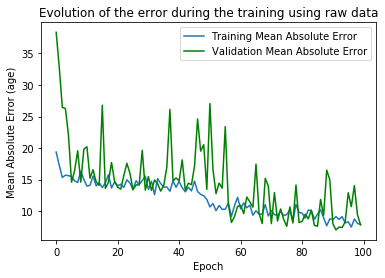

In [30]:
data_training_cole = pd.read_csv("/content/gdrive/My Drive/tp_4/data/training_data/metrics_cole_100_100.csv")
plt.plot(data_training_cole.loc[:, 'epoch'], data_training_cole.loc[:, 'train_loss'], label='Training Mean Absolute Error')
plt.plot(data_training_cole.loc[:, 'epoch'], data_training_cole.loc[:, 'val_loss'], label='Validation Mean Absolute Error', color='green')
plt.legend(loc='upper right')
plt.title('Evolution of the error during the training using raw data')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error (age)')
plt.show()

On peut voir que le modèle donne des performances du même ordre de grandeur que le modèle précédent. Complexifier le modèle davantage ne le rendra pas plus performant. 

#### Etude des résultats

On va tracer l'évolution des performances de nos modèles en fonction du modèle. 

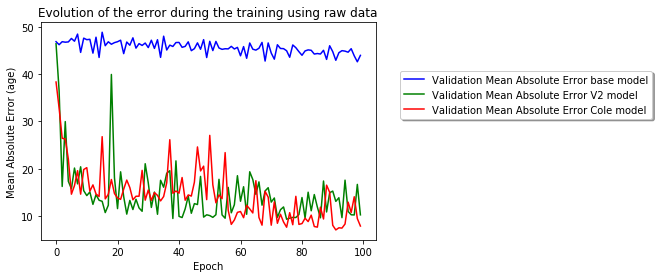

In [31]:
plt.plot(data_training_base.loc[:, 'epoch'], data_training_base.loc[:, 'val_loss'], label='Validation Mean Absolute Error base model', color='blue')
plt.plot(data_training_V2.loc[:, 'epoch'], data_training_V2.loc[:, 'val_loss'], label='Validation Mean Absolute Error V2 model', color='green')
plt.plot(data_training_cole.loc[:, 'epoch'], data_training_cole.loc[:, 'val_loss'], label='Validation Mean Absolute Error Cole model', color='red')
plt.legend(loc='upper center', bbox_to_anchor=(1.45, 0.8), shadow=True, ncol=1)
plt.title('Evolution of the error during the training using raw data')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error (age)')
plt.show()

On peut déduire que la première architecture n'est pas assez complexe pour résoudre notre problème. La deuxième architecture comprend mieux le problème. Un modèle plus complexe ne comprend pas mieux le problème.

Il faudrait surement ajouter des données afin que notre algorithme puisse s'entraîner davantage.

### Le nombre de données

Chargement d'un jeu de données de 500 sujets sains.

In [0]:
data_frame = pd.read_csv("/content/gdrive/My Drive/tp_4/data/IXI.csv")

# Nous allons créer de nouveau jeu de données contenant seulement les variables utilent à l'entraînement de notre modèle
data = data_frame.loc[:, ('t1_norm', 'age')]

train_matrix, test_matrix, val_matrix = train_test_val(data)

# On précise le nombre d'exemple que va contenir chaque batch
batch_size = 4

generator_train = generator_mri_regression(list_path=train_matrix, batch_size=batch_size, shuffle=True)

generator_test = generator_mri_regression(list_path=test_matrix, batch_size=batch_size, shuffle=True)

#### Architecture intermédiaire

In [33]:
model_V2 = model_baseV2(SIZE)
model_V2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1_1 (Conv3D)            (None, 191, 227, 191, 8)  224       
_________________________________________________________________
conv_1_2 (Conv3D)            (None, 189, 225, 189, 8)  1736      
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 94, 112, 94, 8)    0         
_________________________________________________________________
conv_2_1 (Conv3D)            (None, 92, 110, 92, 16)   3472      
_________________________________________________________________
conv_2_2 (Conv3D)            (None, 90, 108, 90, 16)   6928      
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 45, 54, 45, 16)    0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1749600)          

In [0]:
# Call back initialization
test_name = 'model_V2_ixitrain_' + datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")

training_path = '/content/'+test_name
os.mkdir(training_path)

hyperparameters = SaveHyperparameters(training_path, LEARNING_RATE, batch_size, 100, False, 0, 0, 'test_baseline')

save_metrics = SaveMetrics(training_path)

filepath="/content/"+test_name+"/model_saved/"
os.mkdir(filepath)

checkpoint = ModelCheckpoint(filepath+"HCP-test_weights-improvement-{epoch:02d}-{val_mean_absolute_error:.2f}.hdf5", monitor='val_mean_absolute_error', verbose=1, save_best_only=True, mode='min')

callbacks_list = [checkpoint, save_metrics]

In [0]:
# Model initialization
model_V2.compile(loss=['mae'],
              optimizer=SGD(lr=LEARNING_RATE),
              metrics=['mae'])

In [0]:
model_V2.fit_generator(generator=generator_train.loader(),
                    steps_per_epoch=generator_train.get_len(),
                    epochs=5, 
                    verbose=1,
                    validation_data=generator_test.loader(),
                    validation_steps=generator_test.get_len(),
                    validation_freq=1,
                    shuffle=True,
                    initial_epoch=0,
                    callbacks=callbacks_list)

Votre modèle s'entraîne, cet entraînement peut être très long. Pendant l'entraînement nous allons sauvegarder automatiquement les modèles les plus performant et l'évolution des performances durant l'entraînement. 

Vous pouvez ci-dessous charger un modèle entraîner pendant 100 itérations avec le même jeu de données.

In [0]:
model_V2.load_weights('/content/gdrive/My Drive/tp_4/data/models/model-v2_it-100_data-500.hdf5')

Avec les données sauvegardées on peut visualiser l'évolution des performances au cours de l'entraînement.

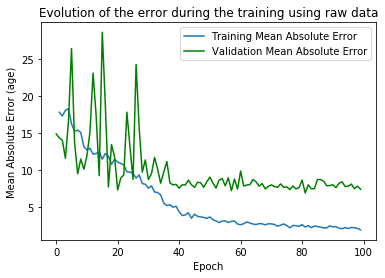

In [37]:
data_training_V2 = pd.read_csv("/content/gdrive/My Drive/tp_4/data/training_data/metrics_v2_100_500.csv")
plt.plot(data_training_V2.loc[1:, 'epoch'], data_training_V2.loc[1:, 'train_loss'], label='Training Mean Absolute Error')
plt.plot(data_training_V2.loc[0:, 'epoch'], data_training_V2.loc[0:, 'val_loss'], label='Validation Mean Absolute Error', color='green')
plt.legend(loc='upper right')
plt.title('Evolution of the error during the training using raw data')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error (age)')
plt.show()

L'ajout de données a permi de résoudre notre problème plus précisément. 

#### Architecture plus élaborée

In [38]:
model_cole =  cole_model(SIZE)
model_cole.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1_1 (Conv3D)            (None, 193, 229, 193, 8)  224       
_________________________________________________________________
conv_1_2 (Conv3D)            (None, 193, 229, 193, 8)  1736      
_________________________________________________________________
bn_1_3 (BatchNormalization)  (None, 193, 229, 193, 8)  772       
_________________________________________________________________
relu_conv_1_4 (ReLU)         (None, 193, 229, 193, 8)  0         
_________________________________________________________________
max_pooling3d_10 (MaxPooling (None, 96, 114, 96, 8)    0         
_________________________________________________________________
conv_2_1 (Conv3D)            (None, 96, 114, 96, 16)   3472      
_________________________________________________________________
conv_2_2 (Conv3D)            (None, 96, 114, 96, 16)  

In [0]:
# Model initialization
model_cole.compile(loss=['mae'],
              optimizer=SGD(lr=LEARNING_RATE),
              metrics=['mae'])

In [0]:
# Call back initialization
test_name = 'cole_ixi_train_' + datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")

training_path = '/content/'+test_name
os.mkdir(training_path)

hyperparameters = SaveHyperparameters(training_path, LEARNING_RATE, batch_size, 100, False, 0, 0, 'test_baseline')

save_metrics = SaveMetrics(training_path)

filepath="/content/"+test_name+"/model_saved/"
os.mkdir(filepath)

checkpoint = ModelCheckpoint(filepath+"HCP-test_weights-improvement-{epoch:02d}-{val_mean_absolute_error:.2f}.hdf5", monitor='val_mean_absolute_error', verbose=1, save_best_only=True, mode='min')

callbacks_list = [checkpoint, save_metrics]

In [0]:
model_cole.fit_generator(generator=generator_train.loader(),
                    steps_per_epoch=generator_train.get_len(),
                    epochs=5, 
                    verbose=1,
                    validation_data=generator_test.loader(),
                    validation_steps=generator_test.get_len(),
                    validation_freq=1,
                    shuffle=True,
                    initial_epoch=0,
                    callbacks=callbacks_list)

Votre modèle s'entraîne, cet entraînement peut être très long. Pendant l'entraînement nous allons sauvegarder automatiquement les modèles les plus performant et l'évolution des performances durant l'entraînement. 

Vous pouvez ci-dessous charger un modèle entraîner pendant 100 itérations avec le même jeu de données.

In [0]:
model_cole.load_weights('/content/gdrive/My Drive/tp_4/data/models/model-cole_it-100_data-500.hdf5')

Avec les données sauvegardées on peut visualiser l'évolution des performances au cours de l'entraînement.

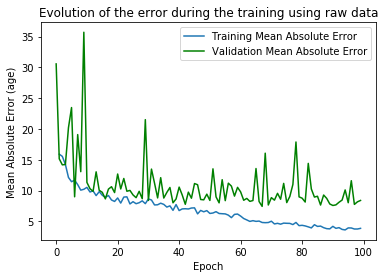

In [42]:
data_training_cole = pd.read_csv("/content/gdrive/My Drive/tp_4/data/training_data/metrics_cole_100_500.csv")
plt.plot(data_training_cole.loc[1:, 'epoch'], data_training_cole.loc[1:, 'train_loss'], label='Training Mean Absolute Error')
plt.plot(data_training_cole.loc[0:, 'epoch'], data_training_cole.loc[0:, 'val_loss'], label='Validation Mean Absolute Error', color='green')
plt.legend(loc='upper right')
plt.title('Evolution of the error during the training using raw data')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error (age)')
plt.show()

L'ajout de données a permi de résoudre notre problème plus précisément. 

#### Etude des résultats

On va tracer l'évolution des performances de nos modèles en fonction du modèle. 

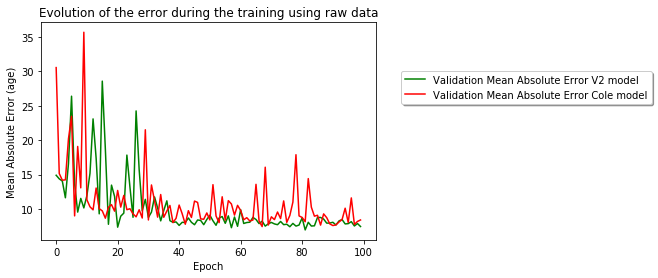

In [43]:
plt.plot(data_training_V2.loc[:, 'epoch'], data_training_V2.loc[:, 'val_loss'], label='Validation Mean Absolute Error V2 model', color='green')
plt.plot(data_training_cole.loc[:, 'epoch'], data_training_cole.loc[:, 'val_loss'], label='Validation Mean Absolute Error Cole model', color='red')
plt.legend(loc='upper center', bbox_to_anchor=(1.45, 0.8), shadow=True, ncol=1)
plt.title('Evolution of the error during the training using raw data')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error (age)')
plt.show()

On voit que nos modèles ont des performances similaires. Mais un modèle plus complexe met en générale plus de temps pour s'entraîner qu'un modèle plus simple. 

### Nombre d'itérations

Nous allons étudier si augmenter le nombre d'itérations va augmenter la performance du modèle le plus complexe par rapport au modèle plus simple.

#### Modèle intermédiaire

In [44]:
model_V2 = model_baseV2(SIZE)
model_V2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1_1 (Conv3D)            (None, 191, 227, 191, 8)  224       
_________________________________________________________________
conv_1_2 (Conv3D)            (None, 189, 225, 189, 8)  1736      
_________________________________________________________________
max_pooling3d_15 (MaxPooling (None, 94, 112, 94, 8)    0         
_________________________________________________________________
conv_2_1 (Conv3D)            (None, 92, 110, 92, 16)   3472      
_________________________________________________________________
conv_2_2 (Conv3D)            (None, 90, 108, 90, 16)   6928      
_________________________________________________________________
max_pooling3d_16 (MaxPooling (None, 45, 54, 45, 16)    0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 1749600)          

In [0]:
# Call back initialization
test_name = 'it300_model_V2_ixitrain_' + datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")

training_path = '/content/'+test_name
os.mkdir(training_path)

hyperparameters = SaveHyperparameters(training_path, LEARNING_RATE, batch_size, 100, False, 0, 0, 'test_baseline')

save_metrics = SaveMetrics(training_path)

filepath="/content/"+test_name+"/model_saved/"
os.mkdir(filepath)

checkpoint = ModelCheckpoint(filepath+"HCP-test_weights-improvement-{epoch:02d}-{val_mean_absolute_error:.2f}.hdf5", monitor='val_mean_absolute_error', verbose=1, save_best_only=True, mode='min')

callbacks_list = [checkpoint, save_metrics]

In [0]:
# Model initialization
model_V2.compile(loss=['mae'],
              optimizer=SGD(lr=LEARNING_RATE),
              metrics=['mae'])

In [0]:
model_V2.fit_generator(generator=generator_train.loader(),
                    steps_per_epoch=generator_train.get_len(),
                    epochs=5, 
                    verbose=1,
                    validation_data=generator_test.loader(),
                    validation_steps=generator_test.get_len(),
                    validation_freq=1,
                    shuffle=True,
                    initial_epoch=0,
                    callbacks=callbacks_list)

Votre modèle s'entraîne, cet entraînement peut être très long. Pendant l'entraînement nous allons sauvegarder automatiquement les modèles les plus performant et l'évolution des performances durant l'entraînement. 

Vous pouvez ci-dessous charger un modèle entraîner pendant 500 itérations avec le même jeu de données.

In [0]:
model_V2.load_weights('/content/gdrive/My Drive/tp_4/data/models/model-v2_it-300_data-500.hdf5')

Avec les données sauvegarder on peut visualiser l'évolution des performances au cours de l'entraînement.

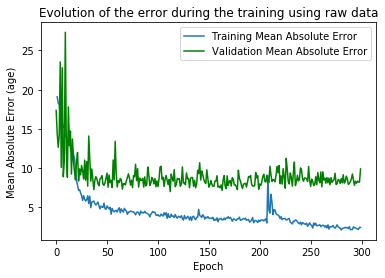

In [48]:
data_training_V2 = pd.read_csv("/content/gdrive/My Drive/tp_4/data/training_data/metrics_v2_it-300_data-500.csv")
plt.plot(data_training_V2.loc[1:, 'epoch'], data_training_V2.loc[1:, 'train_loss'], label='Training Mean Absolute Error')
plt.plot(data_training_V2.loc[0:, 'epoch'], data_training_V2.loc[0:, 'val_loss'], label='Validation Mean Absolute Error', color='green')
plt.legend(loc='upper right')
plt.title('Evolution of the error during the training using raw data')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error (age)')
plt.show()

On voit que l'augmentation de l'itération augmente la performance sur le jeu d'entraînement sans toutefois augmenter la performance sur le jeu de test. C'est le signe du sur-entraînement de notre modèle.

#### Modèle plus élaboré

In [49]:
model_cole =  cole_model(SIZE)
model_cole.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1_1 (Conv3D)            (None, 193, 229, 193, 8)  224       
_________________________________________________________________
conv_1_2 (Conv3D)            (None, 193, 229, 193, 8)  1736      
_________________________________________________________________
bn_1_3 (BatchNormalization)  (None, 193, 229, 193, 8)  772       
_________________________________________________________________
relu_conv_1_4 (ReLU)         (None, 193, 229, 193, 8)  0         
_________________________________________________________________
max_pooling3d_17 (MaxPooling (None, 96, 114, 96, 8)    0         
_________________________________________________________________
conv_2_1 (Conv3D)            (None, 96, 114, 96, 16)   3472      
_________________________________________________________________
conv_2_2 (Conv3D)            (None, 96, 114, 96, 16)  

In [0]:
# Model initialization
model_cole.compile(loss=['mae'],
              optimizer=SGD(lr=LEARNING_RATE),
              metrics=['mae'])

In [0]:
# Call back initialization
test_name = 'it300_cole_ixi_train_' + datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")

training_path = '/content/'+test_name
os.mkdir(training_path)

hyperparameters = SaveHyperparameters(training_path, LEARNING_RATE, batch_size, 100, False, 0, 0, 'test_baseline')

save_metrics = SaveMetrics(training_path)

filepath="/content/"+test_name+"/model_saved/"
os.mkdir(filepath)

checkpoint = ModelCheckpoint(filepath+"HCP-test_weights-improvement-{epoch:02d}-{val_mean_absolute_error:.2f}.hdf5", monitor='val_mean_absolute_error', verbose=1, save_best_only=True, mode='min')

callbacks_list = [checkpoint, save_metrics]

In [0]:
model_cole.fit_generator(generator=generator_train.loader(),
                    steps_per_epoch=generator_train.get_len(),
                    epochs=5, 
                    verbose=1,
                    validation_data=generator_test.loader(),
                    validation_steps=generator_test.get_len(),
                    validation_freq=1,
                    shuffle=True,
                    initial_epoch=0,
                    callbacks=callbacks_list)

Votre modèle s'entraîne, cet entraînement peut être très long. Pendant l'entraînement nous allons sauvegarder automatiquement les modèles les plus performant et l'évolution des performances durant l'entraînement. 

Vous pouvez ci-dessous charger un modèle entraîner pendant 500 itérations avec le même jeu de données.

In [0]:
model_cole.load_weights('/content/gdrive/My Drive/tp_4/data/models/model-cole_it-300_-data.hdf5')

Avec les données sauvegardées on peut visualiser l'évolution des performances au cours de l'entraînement.

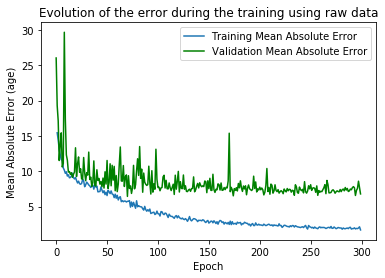

In [53]:
data_training_cole = pd.read_csv("/content/gdrive/My Drive/tp_4/data/training_data/metrics_cole_300_500.csv")
plt.plot(data_training_cole.loc[1:, 'epoch'], data_training_cole.loc[1:, 'train_loss'], label='Training Mean Absolute Error')
plt.plot(data_training_cole.loc[0:, 'epoch'], data_training_cole.loc[0:, 'val_loss'], label='Validation Mean Absolute Error', color='green')
plt.legend(loc='upper right')
plt.title('Evolution of the error during the training using raw data')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error (age)')
plt.show()

On voit que l'augmentation de l'itération augmente la performance sur le jeu d'entraînement sans toutefois augmenter la performance sur le jeu de test. C'est le signe du sur-entraînement de notre modèle.

#### Etude des résultats

On va tracer l'évolution des performances de nos modèles en fonction du modèle. 

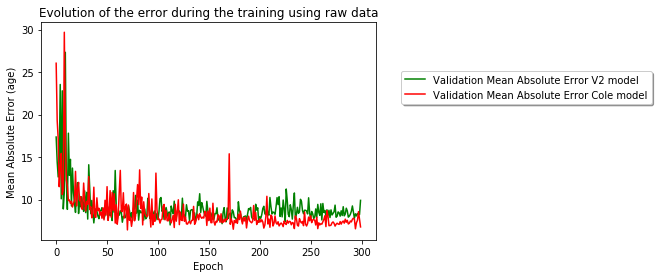

In [54]:
plt.plot(data_training_V2.loc[:, 'epoch'], data_training_V2.loc[:, 'val_loss'], label='Validation Mean Absolute Error V2 model', color='green')
plt.plot(data_training_cole.loc[:, 'epoch'], data_training_cole.loc[:, 'val_loss'], label='Validation Mean Absolute Error Cole model', color='red')
plt.legend(loc='upper center', bbox_to_anchor=(1.45, 0.8), shadow=True, ncol=1)
plt.title('Evolution of the error during the training using raw data')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error (age)')
plt.show()

On peut voir que plus d'itération ont permi à notre modèle plus complexe d'être plus performant que notre premier modèle. Nos modèles souffre de sur-apprentissage. Pour augmenter nos performances par la suite il faudrait utiliser des techniques de régularisation, ou d'obtenir plus de données.